# Stability analysis of ICA components for transcriptomic data   

Here we propose a short analysis of the stability and the reproductibility of ICA components extracted from several gene expression data sets. We are mainly interested in studying the behavior of transcriptomic data extracted from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).

In [1]:
#%load_ext autoreload
#%autoreload 2

import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 0. Load data sets   

### Grossman data set   

These data sets were extracted from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).   
   
df1 contains the expression of 21,766 unique genes for 269 patients with Non-small cell lung cancer (NSCLC) treated at the H. Lee Moffitt Cancer Center, Tampa, Florida, USA. df2 contains the expression of the same 21,766 unique genes for 89 patients with Non-small cell lung cancer (NSCLC)treated at MAASTRO clinical, Maastricht, NL. Gene expression values were measured on a custom Rosetta/Merck Affymetrix 2.0 microarray chipset and normalized with the robust multi-array average (RMA) algorithm. 

In [2]:
df1 = pd.read_excel("data/data_USA.xlsx" , sheet_name = 'expression' , index_col= 0).transpose()
df2 = pd.read_excel("data/data_UE.xlsx" , sheet_name = 'expression' , index_col= 0).transpose()

#With xlrd >= 2.0.0 you will need to use a different engine since xrld removed support for anything 
#other than .xls files (make sure openpyxl is installed). It will usually take a bit of time.
#df1 = pd.read_excel("data/data_USA.xlsx" , engine = 'openpyxl' , sheet_name = 'expression' , index_col= 0).transpose()
#df2 = pd.read_excel("data/data_UE.xlsx" ,  engine = 'openpyxl' , sheet_name = 'expression' , index_col= 0).transpose()

dic = {}
for col in df1.columns:
    dic[col] = int(col.split('.')[1])
    
df1 = df1.rename(columns = dic)
df1['Dataset'] = ['Grossman USA']*df1.shape[0]
df1 = df1.reset_index().rename(columns = {'index' : 'Samples'}).set_index(['Dataset' , 'Samples'])

df2 = df2.rename(columns = dic)
df2['Dataset'] = ['Grossman UE']*df2.shape[0]
df2 = df2.reset_index().rename(columns = {'index' : 'Samples'}).set_index(['Dataset' , 'Samples'])

df1.head()

3643       84263      7171       2934       \
Dataset      Samples                                                        
Grossman USA RadioGenomic-017   5.205151   7.097989   9.559617   8.396808   
             RadioGenomic-055   5.615738   6.585052   9.777869   9.082415   
             RadioGenomic-227   5.679276   7.747854  10.648704   9.127985   
             RadioGenomic-222   5.317341   7.196276  10.949771   8.098896   
             RadioGenomic-212   7.196904   9.346492   9.673778   9.358636   

                               11052      1241       6453       57541      \
Dataset      Samples                                                        
Grossman USA RadioGenomic-017   7.603719   7.990605  10.044401   9.054930   
             RadioGenomic-055   8.639498   6.781274   9.541826   8.866110   
             RadioGenomic-227   7.369421   7.203773   8.972255   8.328371   
             RadioGenomic-222   7.639882   7.971876  10.159637   8.667702   
             RadioGenomic-212   8.741693   7.616498  10.376653   8.701461   

                               9349       11165      ...  643669     \
Dataset      Samples                                 ...              
Grossman USA RadioGenomic-017   7.383169   8.177010  ...   6.419273   
             RadioGenomic-055   6.422702   7.196294  ...   5.753828   
             RadioGenomic-227   7.269232   7.449183  ...   5.666999   
             RadioGenomic-222   8.474250   7.271477  ...   5.531060   
             RadioGenomic-212   6.601991   7.344651  ...   5.519642   

                               1572       8551       26784      26783      \
Dataset      Samples                                                        
Grossman USA RadioGenomic-017   3.809826   6.507880   6.572121   5.400848   
             RadioGenomic-055   4.186127   6.821582   7.031406   4.852417   
             RadioGenomic-227   4.316130   6.637855   6.248824   4.664228   
             RadioGenomic-222   3.403776   7.059419   6.201873   4.690005   
             RadioGenomic-212   3.796049   7.332635   6.050121   4.898523   

                               26782      26779      26778      26777      \
Dataset      Samples                                                        
Grossman USA RadioGenomic-017   5.951391   3.381860   9.825584   2.905091   
             RadioGenomic-055   6.140850   2.629760   9.005145   3.366466   
             RadioGenomic-227   5.767970   2.911470   8.674466   3.337194   
             RadioGenomic-222   6.256286   4.119688   9.099659   3.181781   
             RadioGenomic-212   6.537895   3.600895   8.792510   2.945391   

                               100132941  
Dataset      Samples                      
Grossman USA RadioGenomic-017   5.622438  
             RadioGenomic-055   5.495330  
             RadioGenomic-227   6.308605  
             RadioGenomic-222   5.740033  
             RadioGenomic-212   5.835411  

[5 rows x 21766 columns]

### Lim NSCL data set   

This data set was extracted from ["Data Descriptor: A merged lung cancer transcriptome dataset for clinical predictive modeling" Bin Lim et al. 2018](https://www.nature.com/articles/sdata2018136).   
It gathers 10 independent GEO cohorts of patients with Non-small cell lung cancer (NSCLC) or normal lung tissues. In total, it contains the expression of 10077 unique genes for 1118 patients with Non-small cell lung cancer (NSCLC) or normal lung tissues. The 10 GEO data sets use the same chip platform (Affymetrix Human Genome U133 Plus 2.0 Array). The expression values were normalized with the frozen Robust Multiarray Analysis algorithm (fRMA).   

**Note :** In order to be able to join this data set with the Grossman data set, we converted the official gene symbols to entrez ids. We used [the Database for Annotation, Visualization and Integrated Discovery(DAVID)](https://david.ncifcrf.gov/)

In [3]:
new_data = pd.read_excel("data/new_data.xlsx" , sheet_name=['expression' , 'clinical'] , index_col=0)

#With xlrd >= 2.0.0 you will need to use a different engine since xrld removed support for anything 
#other than .xls files (make sure openpyxl is installed). It will usually take a bit of time.
#new_data = pd.read_excel("data/new_data.xlsx" , engine = 'openpyxl' , sheet_name=['expression' , 'clinical'] , index_col=0)

new_data['expression'] = new_data['expression'].drop(columns = 'gene_name').transpose()

temp = new_data['expression'].join(new_data['clinical'][['Dataset' , 'Histology (ADC: adenocarcinoma; LCC: large cell carcinoma; SCC: squamous cell carcinoma)']])
df3 = temp.reset_index().rename(columns = {'index' : 'Samples'}).set_index(['Dataset' , 'Samples'])

del temp , new_data

df3 = df3[df3['Histology (ADC: adenocarcinoma; LCC: large cell carcinoma; SCC: squamous cell carcinoma)'] != 'Healthy'].drop(columns = 'Histology (ADC: adenocarcinoma; LCC: large cell carcinoma; SCC: squamous cell carcinoma)')
df3.head()

1          2         144571    65985     13      \
Dataset  Samples                                                        
GSE33356 GSM494556  5.234802  11.922797  5.031032  9.141089  9.934807   
         GSM494557  5.069035  11.146006  4.737330  8.926558  4.419542   
         GSM494558  5.514972  12.378934  6.990395  7.268946  4.253987   
         GSM494559  6.871695  11.853862  4.589314  8.874169  5.911853   
         GSM494560  6.761781  11.200515  5.001184  9.027746  5.356248   

                      201651    51166     195827    79719      22848   ...  \
Dataset  Samples                                                       ...   
GSE33356 GSM494556  6.868094  5.038721  6.845863  7.877033   9.201101  ...   
         GSM494557  3.276470  7.517926  6.945466  7.387878   9.279903  ...   
         GSM494558  2.978153  6.286073  7.201963  7.125318  10.170862  ...   
         GSM494559  4.412516  6.304975  7.731857  7.300380   8.649045  ...   
         GSM494560  3.515208  5.545497  7.552539  7.309306   9.229319  ...   

                      9183      55055      11130     7789      158586  \
Dataset  Samples                                                        
GSE33356 GSM494556  7.149422  7.737312   8.386004  5.994052  7.685643   
         GSM494557  7.307666  7.693829   9.986055  5.808656  5.968874   
         GSM494558  6.886556  7.927103   8.124558  5.526909  6.000892   
         GSM494559  7.939107  8.589020   9.673297  6.190925  6.736635   
         GSM494560  7.833734  8.689572  10.304345  6.090843  6.703918   

                      440590    79699     7791      23140     26009   
Dataset  Samples                                                      
GSE33356 GSM494556  4.546110  8.870484  7.938569  7.596789  8.049103  
         GSM494557  4.979624  9.177783  7.976926  7.044507  8.192161  
         GSM494558  4.951939  8.613027  8.642108  7.747791  7.947040  
         GSM494559  4.765782  9.643763  7.295604  7.839339  8.377581  
         GSM494560  5.821131  9.187349  7.557380  7.320086  8.827688  

[5 rows x 10077 columns]

We only keep data sets with more than 89 samples to avoid ending up with very noisy ICA components which will compromise the stability analysis.

In [4]:
dataframe = pd.concat([df1, df2 , df3], join = 'inner')
names = list(dataframe.index.unique(0))

exclude = []
print("Data sets in the study : ")   
for name in names:
    n_samples = dataframe.loc[name].shape[0]
    if n_samples < 89:
        exclude.append(name)
    else:
       print(name , n_samples)
        
del df1 , df2 , df3

names = list(set(names) - set(exclude))

Data sets in the study : 
Grossman USA 262
Grossman UE 89
GSE19188 91
GSE28571 100
GSE50081 181
GSE31210 226
GSE18842 91


## 1. Most Stable Transcriptome Dimension (MSTD)   

In order to select the number of ICA components we refer to ["Determining the optimal number of independent components for reproducible transcriptomic data analysis" Kairov et al. 2017](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-017-4112-9). The idea is to find a trade-off between a sufficiently large number of components to capture all essential information and a restricted dimension to avoid ending up with a lot of very unstable components which only capture noise.   

To do so we plot the stability distribution for a wide range of different number of components M = 5, ... , 100 and we observe which choice of M most satisfies the trade-off the most.

  0%|          | 0/49 [00:00<?, ?it/s]

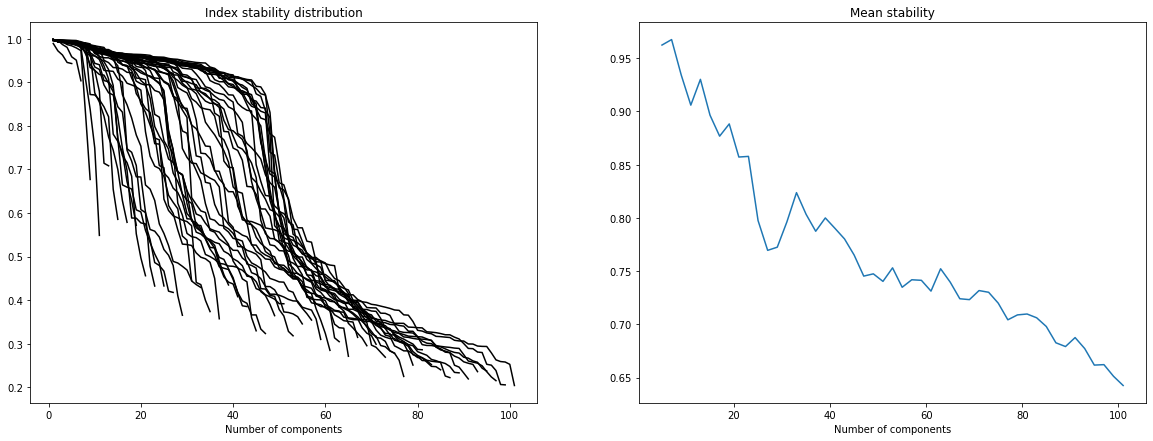

In [5]:
#MSTD plot for the data set GSE31210.
from sica.base import MSTD
X = dataframe.loc['GSE31210'].apply(func = lambda x : x - x.mean() , axis = 0)
MSTD(X , 5 , 100 , 2 , 20 , max_iter = 3000)
#MSTD(X.values , 5 , 100 , 2 , 20 , max_iter = 3000)

In [5]:
MSTD = 45

## 2. Stabilized ICA decompostion for each data set   

Our stabilized ICA algorithm is a copy of the ICASSO algorithm (implemented in MATLAB) ["ICASSO: software for investigating the reliability of ICA estimates by clustering and visualization" Himberg et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/Himberg03.pdf) The main idea is to iterate several times the FastICA algorithm (ex: from sklearn), cluster the results (agglomerative hierarchical clustering) and define the final ICA components as the centrotype of each cluster.

In [6]:
from sica.base import StabilizedICA as sICA

In [7]:
Sources = []
decomp = sICA(n_components = MSTD , n_runs = 30, n_jobs = -1)

for name in names:
    start = time.time()
    X = dataframe.loc[name].apply(func = lambda x : x - x.mean() , axis = 0)
    #decomp.fit(X.values)
    decomp.fit(X)
    Sources.append(decomp.S_ )
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(name + " done !" , "running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

GSE28571 done ! running time (min): 00:26.97
Grossman UE done ! running time (min): 00:14.99
GSE31210 done ! running time (min): 00:16.52
Grossman USA done ! running time (min): 00:17.24
GSE18842 done ! running time (min): 00:20.98
GSE50081 done ! running time (min): 00:19.28
GSE19188 done ! running time (min): 00:20.64


## 3. Study of reproducibility - MNN graph

In order to study the reproducibility of ICA components between the four data sets we use the notion of Reciprocal Best Hit (RBH). We consider that a component $i$ extracted from a data set D1 and another component $j$ extracted from a data set D2 are linked if:   

\begin{equation}
|\rho_{ij}| = \max \{ |\rho_{ik}| , \forall k \, \in D2 \} = \max \{ |\rho_{lj}| , \forall l \, \in D1 \}
\end{equation}

Here $\rho_{ij}$ represents the Pearson's correlation coefficient between the components $i$ and $j$. We chose to use Pearson's coefficient over non-parametric coefficients such as Kendall's or Spearman's coefficients since it is strongly influenced by extreme values. Yet in our case these extreme values characterize our ICA components .

In [8]:
from sica.mutualknn import MNNgraph

**Note :** The layout of the following RBH network is strongly influenced by a random initialisation (Fruchterman-Reingold force-directed algorithm). One may have to run the following result several times to obtain a satisfying result.

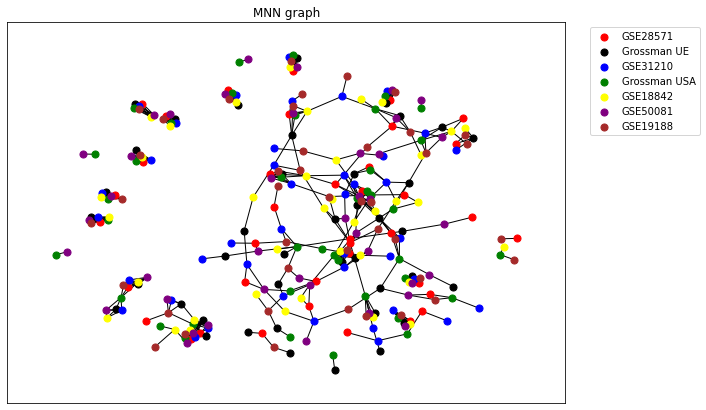

In [9]:
fig , ax = plt.subplots(figsize = (10 , 7))

cg = MNNgraph(data = Sources , names = names , k=1, weighted=False)
cg.draw(ax=ax, colors = ['r' , 'k' , 'b' , 'g' , 'yellow' , 'purple' , 'brown'] , spacing = 2)

ax.legend(bbox_to_anchor=(1.25 , 1))

In [14]:
cg.export_json("stability.json")

We can also draw the bipartite RBH graph for the ICA components of two data sets. We display the Pearson correlation coefficient for each link. In the following we display the bipartite graphs for the couples of sets ('Grossman UE' , 'GSE19188') and ('Grossman UE' , 'GSE50081').

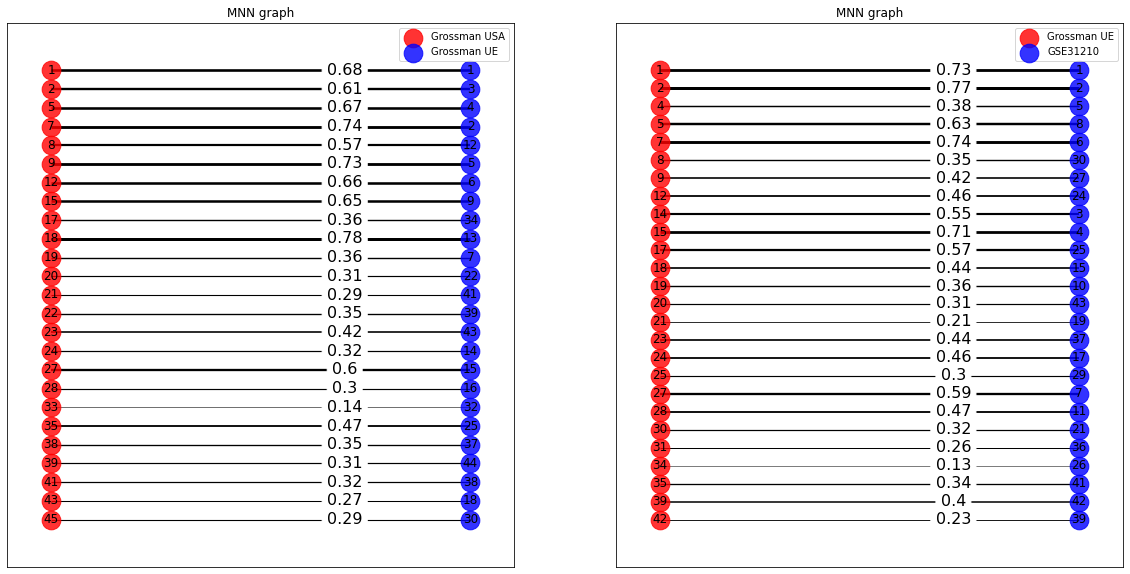

In [12]:
fig , axes = plt.subplots(1 , 2 , figsize=(20 , 10))
for i in range(2):
    cg = MNNgraph(data = [Sources[0] , Sources[i+1]] , names = [names[i] , names[i+1]] , k=1)
    cg.draw(ax=axes[i] , bipartite_graph = True)

## 4. Cytoscape visualization of the stability network

In order to visualize the stability network with cytoscape directly on the jupyter notebook we use the [ipycytoscape package](https://github.com/QuantStack/ipycytoscape). Please install it with:   
* conda install -c conda-forge ipycytoscape
* pip install ipycytoscape

In [19]:
import ipycytoscape
import json

with open("stability.json") as fi:
    json_file = json.load(fi)
    
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(json_file['elements'])

cytoscapeobj.set_layout(name = 'cose')

In [20]:
cytoscapeobj.set_style([{'selector': 'node',
                            'css': {
                                  'content': 'data(name)',
                                  'font-size': '12px',
                                  'text-valign': 'center',
                                  'text-halign': 'center',
                                  'background-color': 'blue',
                                  'color': 'b',
                                }
                        },
                        {'selector': 'edge',
                            'css': {
                                  'curve-style': 'haystack',
                                  'haystack-radius': '0.5',
                                  'opacity': '0.7',
                                  'line-color': '#bbb',
                                  'width': 'mapData(weight , 0 , 1 , 1 , 15)',
                                  'overlay-padding': '3px'
                                }
                        }])

In [21]:
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…